In [1]:
import h5py
from dspeed import build_dsp
import numpy as np
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
import scipy.special as sp
import scipy.optimize as opt
import multiprocessing as mp

In [ ]:
### MORE ANALYSIS OF KAMMEL DATA ###

In [2]:
file1 = "raw/DataR_CH1@DT5730_1463_alpha_split.lh5" # path to raw file
file2 = "raw/DataR_CH1@DT5730_1463_pulse_split.lh5"
file3 = "raw/DataR_CH1@DT5730_1463_hole_backside.lh5"
file4 = "raw/DataR_CH1@DT5730_1463_hole_frontside.lh5"
file5 = "raw/DataR_CH1@DT5730_1463_hole_pulser.lh5"
dsp_file_ex = "processed/DataR_CH1@DT5730_1463_alpha_split_dsp.lh5" # path to output dsp file but we dont need this here
out_start1 = "processed/150_alpha/trap_"
out_start2 = "processed/150_pulse/trap_"
out_start3 = "processed/hole_back/trap_"
out_start4 = "processed/hole_front/trap_"
out_start5 = "processed/hole_pulse/trap_"
out_start_wfs = "processed/wfs_"

In [3]:
dsp_config = {
    "outputs": ["bl", "trapEftp"],
    "processors": {
        "bl, bl_sig, bl_slope, bl_intercept": {
            "function": "linear_slope_fit",
            "module": "dspeed.processors",
            "args": ["waveform[:1000]", "bl", "bl_sig", "bl_slope", "bl_intercept"],
            "unit": ["ADC", "ADC", "ADC", "ADC"]
        },
        "wf_blsub": {
                "function": "subtract",
                "module": "numpy",
                "args": ["waveform", "bl", "wf_blsub"],
                "unit": "ADC"
            },
        "wf_pz": {
                "function": "pole_zero",
                "module": "dspeed.processors",
                "args": ["wf_blsub", "db.pz_tau", "wf_pz"],
                "unit": "ADC"
            },
        "wf_etrap": {
                "function": "trap_norm",
                "module": "dspeed.processors",
                "args": ["wf_pz", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
                "unit": "ADC"
            },
        "trapEftp": {
                "function": "fixed_time_pickoff",
                "module": "dspeed.processors",
                "args": ["wf_etrap", "db.ftp", "'l'", "trapEftp"], 
                "unit": "ADC"
            }
    }    
}

In [4]:
dsp_config2 = {
    "outputs": ["bl", "trapEftp", "wf_pz1", "wf_pz2", "wf_blsub", "wf_etrap"],
    "processors": {
        "bl, bl_sig, bl_slope, bl_intercept": {
            "function": "linear_slope_fit",
            "module": "dspeed.processors",
            "args": ["waveform[:1000]", "bl", "bl_sig", "bl_slope", "bl_intercept"],
            "unit": ["ADC", "ADC", "ADC", "ADC"]
        },
        "wf_blsub": {
                "function": "subtract",
                "module": "numpy",
                "args": ["waveform", "bl", "wf_blsub"],
                "unit": "ADC"
            },
        "wf_pz1": {
                "function": "pole_zero",
                "module": "dspeed.processors",
                "args": ["wf_blsub", "db.pz_tau1", "wf_pz1"],
                "unit": "ADC"
            },
        "wf_pz2": {
                "function": "pole_zero",
                "module": "dspeed.processors",
                "args": ["wf_pz1", "db.pz_tau2", "wf_pz2"],
                "unit": "ADC"
            },
        "wf_etrap": {
                "function": "trap_norm",
                "module": "dspeed.processors",
                "args": ["wf_pz2", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
                "unit": "ADC"
            },
        "trapEftp": {
                "function": "fixed_time_pickoff",
                "module": "dspeed.processors",
                "args": ["wf_etrap", "db.ftp", "'l'", "trapEftp"], 
                "unit": "ADC"
            }
    }    
}

In [5]:
def process_data(file, out, rise, flat, pz_tau1= 0.005, pz_tau2=0.005, example=False, config=dsp_config):
    if example:
        out_path = out
    else:
        out_path = out + f"rise_{rise:.2f}_flat_{flat:.2f}.lh5"
    
    dsp_db = {
        "CompassEvent": {
            "pz_tau1": f"{pz_tau1}*ms",
            "pz_tau2": f"{pz_tau2}*ms",
            "etrap": {
                "rise": f"{rise}*us",
                "flat": f"{flat}*us"
            },
            "ftp": 1000 + (rise + 0.5*flat)/(0.002)
        }
    }
  
    build_dsp(
        f_raw=file, 
        f_dsp=out_path,
        lh5_tables = f"CompassEvent",
        dsp_config = config,
        database = dsp_db,
        write_mode = 'r'
    )

def make_iterable(rises, flats):
    iterable = []
    for rise in rises:
        for flat in flats:
            iterable.append((rise,flat))
    return iterable

In [6]:
rises_chunk = np.linspace(0.1, 5, 50) # Change this
flats_chunk = np.linspace(0.1, 1, 10)
cores = 6

iterable = make_iterable(rises_chunk, flats_chunk)
#print(iterable)
chunk = int(round(len(rises_chunk)*len(flats_chunk)/cores))

'''
with mp.Pool(processes=cores) as p:
    p.starmap(process_data, iterable, chunksize=chunk)
            
'''

'\nwith mp.Pool(processes=cores) as p:\n    p.starmap(process_data, iterable, chunksize=chunk)\n            \n'

In [7]:
####### NECESSARY GLOBAL VARIABLES ########
bins = np.linspace(0, 700, 1401)          #
binwidth = bins[1] - bins[0]              #
bin_centers = bins[:-1] + binwidth/2      #
print(binwidth)                           #
print(bins)                               #
print(bin_centers)                        #
###########################################

0.5
[0.000e+00 5.000e-01 1.000e+00 ... 6.990e+02 6.995e+02 7.000e+02]
[2.5000e-01 7.5000e-01 1.2500e+00 ... 6.9875e+02 6.9925e+02 6.9975e+02]


In [8]:
def select_n_cut(dsp_file, range = False):
    f = h5py.File(dsp_file)
    trapEftp = f['CompassEvent']['trapEftp']
    if range:
        noise_cut = trapEftp[range[0]:range[1]]
    else:
        noise_cut = trapEftp[:]

    #noise_cut = noise_cut[noise_cut > 400]
    return noise_cut


def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


# Define the fit function 
def fit_func(x, mu, sigma, eta, tau1, tau2):
    return 0.5 * (((1-eta)/tau1 * np.exp((x-mu)/tau1 + 0.5*(sigma/tau1)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau1)))
                  + (eta/tau2 * np.exp((x-mu)/tau2 + 0.5*(sigma/tau2)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau2))))


# Define the cdf of the fit function
def cdf_fit_func(x, A, mu, sigma, eta, tau1, tau2):
    return A * np.cumsum(fit_func(x, mu, sigma, eta, tau1, tau2)) * binwidth


# Iminuit optimizer function takes actual data and returns the optimized fit and params 
def optimizer(counts, gimme_moar=False):
    c = cost.ExtendedBinnedNLL(counts, bins, cdf_fit_func)
    m = Minuit(c, A=10000, mu=600, sigma=5, eta=0.25, tau1=20, tau2=20)
    m.limits["A"] = (2000, 14000)
    m.limits["sigma"] = (0.5,35)
    m.limits["tau1"] = (0.05, 1000)
    m.limits["tau2"] = (0.05, 1000)
    m.limits['eta'] = (0,1)
    var = m.migrad()  # need to call migrad but prob dont need the return variable
    A_fit = m.values['A']
    mean_fit = m.values['mu']
    std_fit = m.values['sigma']
    eta_fit = m.values['eta']
    tau1_fit = m.values['tau1']
    tau2_fit = m.values['tau2']
    fwhm_fit = 2.355*std_fit
    energy_fwhm = fwhm_fit*3271.2/mean_fit
    energy_resolution = fwhm_fit/mean_fit

    minuit_fit = A_fit * fit_func(bins, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit)
    if gimme_moar:
        return minuit_fit, c, A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit, fwhm_fit, energy_fwhm, energy_resolution
    else:
        return minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution


# Plotting function which plots the fit and the data along with some other info
def plot_fit(noise_cut, minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution, g_fit_package = False, rise = False, flat = False):
    #plt.plot(x, test_fit, color='green', label='Test Fit', alpha = 0.75)
    plt.hist(noise_cut, bins=bins, color='blue', alpha=0.5)
    plt.plot(bins, minuit_fit, color='red', label='Minuit Fit', alpha = 0.75)
    if g_fit_package:
        plt.plot(bin_centers, g_fit_package[0], color='black', label='Half-Gaussian Fit')
        plt.text(0.02, 0.55, 'Half-Gaussian Fit Energy_Resolution:' + str(round(g_fit_package[1]*100, 2)) + '%', transform=plt.gca().transAxes)
        plt.text(0.02, 0.6, 'Half-Gaussian Fit Energy_FWHM:' + str(round(g_fit_package[2], 2)) + ' keV', transform=plt.gca().transAxes)
    plt.axvline(mean_fit, color='black', linestyle='--', label='Minuit Mean: ' + str(round(mean_fit, 2)))
    plt.axvline(mean_fit + fwhm_fit/2, color='black', linestyle=':', label='Minuit FWHM: ' + str(round(fwhm_fit, 2)))
    plt.axvline(mean_fit - fwhm_fit/2, color='black', linestyle=':')
    plt.text(0.02, 0.65, 'Minuit Energy Resolution: ' + str(round(energy_resolution*100, 2)) + '%', transform=plt.gca().transAxes)
    plt.text(0.02, 0.7, 'Minuit Energy FWHM: ' + str(round(energy_fwhm, 2)) + ' keV', transform=plt.gca().transAxes)
    plt.xlim(550, 607)

    if rise and flat:
        plt.title(f'Gd-148 Alpha Spectrum [Rise: {rise:.2f}us, Flat: {flat:.2f}us]')
    else:
        plt.title('Gd-148 Alpha Spectrum')
    plt.xlabel('Energy (ADC)')
    plt.ylabel('Counts')
    #plt.ylim(1e-2, 2e2)
    #plt.yscale('log')
    plt.legend()
    #plt.ylim(1e-1, 2e3)
    #plt.yscale('log')
    plt.show()

def plot_heat_map(e_fwhm_array, rises, flats):
    figgy, axs = plt.subplots(figsize=(10, 10))
    im = axs.imshow(e_fwhm_array, origin='lower')
    round_rises = np.around(rises, 2)
    round_flats = np.around(flats, 2)
    axs.set_xticks(np.arange(len(flats)), labels=round_flats)
    axs.set_yticks(np.arange(len(rises)), labels=round_rises)
    plt.setp(axs.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    axs.set_title("Energy Resolution vs Rise and Flat Times")
    axs.set_xlabel("Flat Time (us)")
    axs.set_ylabel("Rise Time (us)")
    plt.colorbar(im)
    figgy.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
    plt.show()


In [10]:
process_data(file1, dsp_file_ex, 4, 0.2, pz_tau1 = 0.004, pz_tau2 = 0.6, example=True, config=dsp_config2)

Processing table CompassEvent:  20%|##        | 3200/15625 [00:11<00:46, 269.39 rows/s]

[1230.4097 1273.624  1160.5461 ... 1231.305  1247.1791 1230.8225]
6.0 0.010075566750629723


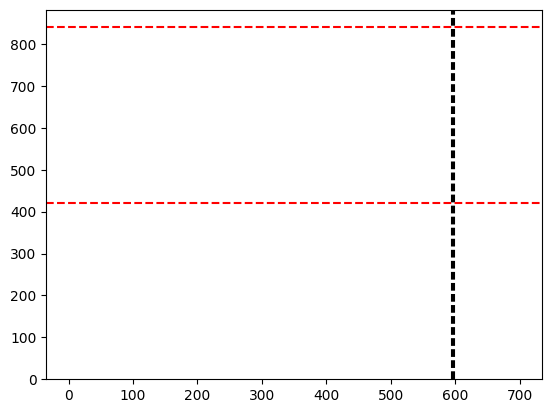

In [9]:
dat = select_n_cut(dsp_file_ex)
print(dat)
meany = 595.5
upper = 598.5
plt.hist(dat, bins=bins, color='blue')
plt.axvline(meany, color='black', linestyle='--')
plt.axvline(upper, color='black', linestyle='--')
plt.axhline(420, color='red', linestyle='--')
plt.axhline(840, color='red', linestyle='--')
#plt.xlim(500, 607)
fwhm_eye = (upper-meany) * 2
e_res_eye = fwhm_eye/meany
print(fwhm_eye, e_res_eye)

In [10]:
from numba import guvectorize

# need to already have a numpy array ready for the output 
# tau passed to func in ms
@guvectorize(["(float32[:], float32, float32[:])"], "(n),()->(n)", nopython=True)
def polezero(w_in: np.ndarray, tau: float, w_out: np.ndarray):
    tau = tau * 1e6 # convert from ms to ns
    tau = tau / 2  # convert from ns to 2ns samples
    const = np.exp(-1 / tau)
    w_out[0] = w_in[0]
    for i in range(1, len(w_in), 1):
        w_out[i] = w_out[i - 1] + w_in[i] - w_in[i - 1] * const

In [11]:
@guvectorize(
    [
        "void(float32[:], float32, float32, float32, float32[:])",
        "void(float64[:], float64, float64, float64, float64[:])",
    ],
    "(n),(),(),()->(n)",
)

def double_pole_zero(
    w_in: np.ndarray, t_tau1: float, t_tau2: float, frac: float, w_out: np.ndarray
    ) -> np.ndarray:

    t_tau1 = t_tau1 * 1e6 # convert from ms to ns
    t_tau1 = t_tau1 / 2  # convert from ns to 2ns samples
    t_tau2 = t_tau2 * 1e6
    t_tau2 = t_tau2 / 2

    w_out[:] = np.nan

    if np.isnan(w_in).any() or np.isnan(t_tau1) or np.isnan(t_tau2) or np.isnan(frac):
        return
    if len(w_in) <= 3:
        raise Exception(
            "The length of the waveform must be larger than 3 for the filter to work safely"
        )

    a = np.exp(-1 / t_tau1)
    b = np.exp(-1 / t_tau2)

    transfer_denom_1 = frac * b - frac * a - b - 1
    transfer_denom_2 = -1 * (frac * b - frac * a - b)
    transfer_num_1 = -1 * (a + b)
    transfer_num_2 = a * b

    # Create a buffer of float64s, because performing the recursion at float32 causes instabilities in the filter due to truncation
    w_tmp = np.zeros(3, dtype=np.float64)

    # Initialize the arrays for recursion
    w_tmp[0] = w_in[0]
    w_tmp[1] = w_in[1]

    w_out[0] = w_in[0]
    w_out[1] = w_in[1]

    for i in range(2, len(w_in), 1):
        w_tmp[2] = (
            w_in[i]
            + transfer_num_1 * w_in[i - 1]
            + transfer_num_2 * w_in[i - 2]
            - transfer_denom_1 * w_tmp[1]
            - transfer_denom_2 * w_tmp[0]
        )

        w_out[i] = w_tmp[2]  # Put the higher precision buffer into the desired output
        # Shuffle the buffer for the next iteration
        w_tmp[0] = w_tmp[1]
        w_tmp[1] = w_tmp[2]
    # Check the output
    if np.isnan(w_out).any():
        raise Exception("Double-pole-zero filter produced nans in output.")


In [12]:
# params = (tau1, tau2, frac), args = (wf_blsub)

def dpz_workhorse(params, args):
    w_out = np.zeros(len(args[0]))
    max = np.max(args[0])
    argmax = np.argmax(args[0])
    double_pole_zero(args[0], params[0], params[1], params[2], w_out)
    w_out = w_out[argmax:4001]
    residuals = w_out - max
    return residuals, w_out, max


def dpz_optimizer_func(params, args):
    residuals, w_out, max = dpz_workhorse(params, args)
    return np.sum(residuals**2)

In [13]:
f = h5py.File(dsp_file_ex)
wf_blsub = f['CompassEvent']['wf_blsub']['values']
wf_pz1 = f['CompassEvent']['wf_pz1']['values']
wf_pz2 = f['CompassEvent']['wf_pz2']['values']
wf_etrap = f['CompassEvent']['wf_etrap']['values']

super_wf_blsub = np.average(wf_blsub/np.max(wf_blsub, axis=1)[:,None], axis=0)
super_wf_pz1 = np.average(wf_pz1/np.max(wf_pz1, axis=1)[:,None], axis=0)
super_wf_pz2 = np.average(wf_pz2/np.max(wf_pz2, axis=1)[:,None], axis=0)
super_wf_etrap = np.average(wf_etrap/np.max(wf_etrap, axis=1)[:,None], axis=0)

Text(0.5, 0, 'Time (2 ns samples)')

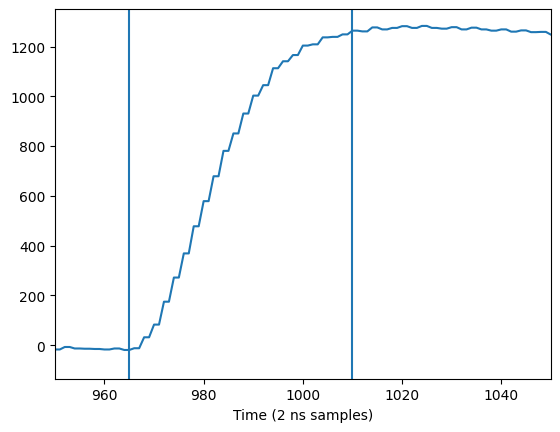

In [17]:
plt.plot(wf_blsub[0])
plt.xlim(950, 1050)
plt.axvline(965)
plt.axvline(1010)
plt.xlabel('Time (2 ns samples)')

In [16]:
results = opt.minimize(dpz_optimizer_func, [0.0058, 0.00075, 0.25], args=(wf_blsub))
tau1, tau2, frac = results.x
print(results.x)

[0.00525336 0.00132547 0.25      ]


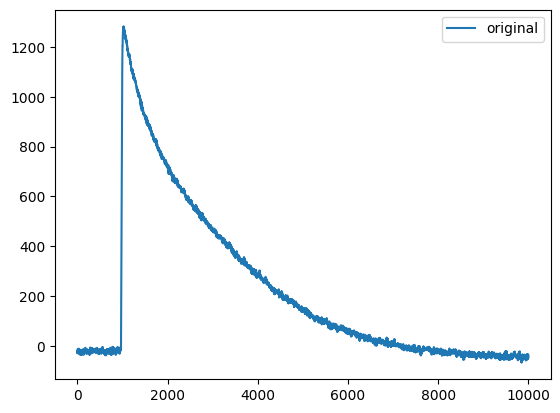

In [17]:
plt.plot(wf_blsub[0], label="original")
#plt.plot(wf_pz1[0], label="pz1 corrected")
#plt.plot(wf_pz2[0], label="pz2 corrected")
#plt.plot(wf_etrap[0], label="etrap")
plt.legend()


In [38]:
my_wf_pz1 = np.zeros(len(super_wf_blsub))
polezero(super_wf_blsub, 0.0057, my_wf_pz1)
my_wf_pz2 = np.zeros(len(super_wf_pz1))
polezero(super_wf_blsub, tau2, my_wf_pz2)
sum_my_wf_pz = (1-frac)*my_wf_pz1 + frac*my_wf_pz2

my_wf_dpz = np.zeros(len(super_wf_blsub))
double_pole_zero(super_wf_blsub, 0.007, 0.0008, 0.22, my_wf_dpz)




array([-0.0169537 , -0.0169537 , -0.01725614, ...,  0.63803905,
        0.63800144,  0.63798904])

In [28]:
def exp(x, A, tau, offset):
    tau = tau * 1e6 # convert from ms to ns
    tau = tau / 2  # convert from ns to 2ns samples
    return A * np.exp((-x+offset)/tau)

x = np.linspace(0, 10000, 10001)
exp1 = exp(x, 1, 0.0057, 0)
exp2 = exp(x, 1, 0.003, 1000)

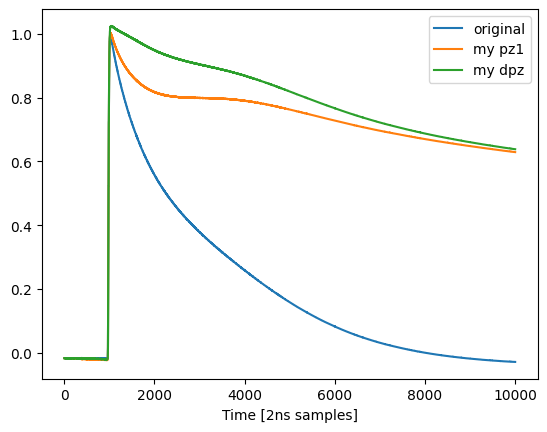

In [39]:
#plt.figure(figsize=(12,10))
plt.plot(super_wf_blsub, label="original")
#plt.plot(super_wf_pz1, label="pz1 corrected")
#plt.plot(super_wf_pz2, label="pz2 corrected")
#plt.plot(super_wf_etrap, label="etrap")

plt.plot(my_wf_pz1, label="my pz1")
#plt.plot(my_wf_pz2, label="my pz2")
plt.plot(my_wf_dpz, label="my dpz")


#plt.plot(exp1, label="exp1")
#plt.plot(exp2, label="exp2")

#plt.axvline((1000 + (4 + 0.5*0.2)/(0.002)), label="ftp")
#plt.axhline(0.82, color='black', linestyle='--')
plt.xlabel("Time [2ns samples]")
#plt.yscale('log')
plt.legend()
#plt.xlim(900, 3000)
#plt.xlim(750,1250)
#print(rise)